## <center> Content-based recommender models </center>

In [1]:
import warnings

warnings.filterwarnings("ignore")
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import collections
import numpy as np
import os
import pandas as pd
import torch
import torch.nn.functional as F

from itertools import islice, cycle, product
from lightfm.data import Dataset
from lightfm import LightFM
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from utils.data import MatchDataGenerator, df_to_dict
from utils.basic_layers import MLP, EmbeddingLayer
from utils.features import SparseFeature, SequenceFeature
from utils.match import Annoy, generate_seq_feature_match, gen_model_input
from utils.metrics import topk_metrics
from utils.trainer import MatchTrainer

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
torch.manual_seed(42)

**Ключевая идея** - давайте попробуем учиться не только на взаимодействиях users и items, но и добавлять в модель имеющиеся по ним признаки.

Способов немало, но сегодня разберем наиболее интересные и распространенные примеры:
- DSSM и ее адаптации
- LightFM

#### DSSM (Deep Structured Semantic Model) 

Вспомним, как выглядела оригинальная модель DSSM для задачи ранжирования выдачи поиска.  

<img src='https://kishorepv.github.io/images/DSSM_layers.png' width=700>

где $R(Q, D) = cosine(y_{Q}, y_{D}) = \dfrac{y_{Q}^{T} y_{D}}{||y_{Q}|| \cdot ||y_{D}||}$. 

При этом, считаем оценку семантической релевантности текущего документа и запроса как:

$$P(D|Q) = \frac{exp(\gamma R(Q, D))}{\sum_{D' \in D}exp(\gamma R(Q, D') }$$

Проблема со знаменателем давно известна, поэтому минимизировать будем следующую функцию:

$$L (Λ) = - log \prod_{(Q, D^{+})} P(D^{+}|Q)$$

Слева - уже знакомая нам постановка задачи для матричной факторизации. Справа - как можем модифицировать DSSM под решение задачи рекомендаций и с обогащением признаками.

<img src='images/dot_prod.png' width=600>

In [2]:
"""
References: 
    paper: (CIKM'2013) Learning Deep Structured Semantic Models for Web Search using Clickthrough Data
    url: https://posenhuang.github.io/papers/cikm2013_DSSM_fullversion.pdf
    code: https://github.com/bbruceyuan/DeepMatch-Torch/blob/main/deepmatch_torch/models/dssm.py
"""


class DSSM(torch.nn.Module):
    """Deep Structured Semantic Model
    Args:
        user_features (list[Feature Class]): training by the user tower module.
        item_features (list[Feature Class]): training by the item tower module.
        temperature (float): temperature factor for similarity score, default to 1.0.
        user_params (dict): the params of the User Tower module,
        keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}.
        item_params (dict): the params of the Item Tower module, keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}.
    """

    def __init__(self, user_features, item_features, user_params, item_params, temperature=1.0):
        super().__init__()
        self.user_features = user_features
        self.item_features = item_features
        self.temperature = temperature
        self.user_dims = sum([f.embed_dim for f in user_features])
        self.item_dims = sum([f.embed_dim for f in item_features])

        self.embedding = EmbeddingLayer(user_features + item_features)
        self.user_mlp = MLP(self.user_dims, output_layer=False, **user_params)
        self.item_mlp = MLP(self.item_dims, output_layer=False, **item_params)
        self.mode = None

    def forward(self, x):
        # (b_size, d)
        user_embedding = self.user_tower(x)
        item_embedding = self.item_tower(x)
        if self.mode == "user":
            return user_embedding
        if self.mode == "item":
            return item_embedding
        # (batch_size)
        y = torch.sum(user_embedding * item_embedding, dim=1) * self.temperature

        return torch.sigmoid(y)

    def item_tower(self, x):
        if self.mode == "user":
            return None
        # Какая тут размерность?
        input_item = self.embedding(x, self.item_features, squeeze_dim=True)
        item_embedding = self.item_mlp(input_item)
        item_embedding = F.normalize(item_embedding, p=2, dim=1)
        return item_embedding

    def user_tower(self, x):
        if self.mode == "item":
            return None
        input_user = self.embedding(x, self.user_features, squeeze_dim=True)
        user_embedding = self.user_mlp(input_user)
        user_embedding = F.normalize(user_embedding, p=2, dim=1)
        return user_embedding

* Про температуру

Обычно, при более высокой температуре вероятности становятся более равномерными, что означает, что модель более "размазывает" вероятности между различными классами или вариантами ответов. 

Кстати, recap, как называется архитектура с картинки ниже?

Сравните ее еще раз с архитектурами DSSM и CF (ч.с. MF) и не путайте =)

<img src='images/NCF.png' width=400>

Есть много имплементаций DSSM, можно посмотреть, например, в библиотеке [RecBole](https://github.com/RUCAIBox/RecBole/blob/4b6c6fef9b2f21326876f81e5d76631b280b0909/recbole/model/context_aware_recommender/dssm.py)

<img src='images/dot_prod.png' width=600>

Как будем оптимизировать для RecSys? Лоссы можно выбирать разные. Самые простые из них:

* **Кросс-энтропия**

$\hat p_{ui} = \sigma (R(u, i)) = \sigma(y_{u}^T y_{i})$ - вероятность, что юзер совершит действие с айтемом.

Тогда функция потерь:

$L = - \sum_{u, i} (r_{ui}\cdot log \hat p_{ui} + (1 - r_{ui}) \cdot log(1 - \hat p_{ui}))$

* **Triplet loss**

Рассматриваем тройки из пользователя, положительного примера для него и отрицательного - $R(u, i_{+}, i_{-})$

$L _{margin}(u,i,j)=max(0, margin + sim(u,i) − sim(u,j))$

То есть, пытаемся увеличивать разницу, задавая некоторый порог (отступ) альфа. 

Для pairwise лоссов: 

$L _{BPR}(u,i,j)= - log(\sigma(sim(u,i) − sim(u,j))$

* Давайте тут остановимся и подумаем, какие варианты negative sampling при оптимизации лосса тут можно использвать?

* Какие признаки можно использовать по users, items в качестве input данных? 

* Какие преимущества и недостатки у DSSM модели?


| Метод | Достоинства  |  Недостатки | 
|---|---|---|
| DSSM| Может выявить нелинейные закономерности  |  Дополнительная работа с признаками и оценкой их вклада|  
|
|| Real-time inference на проде | Необходимость подбора параметров и тюнинга гиперпараметров |  
|
|| Возможность добавлять признаки разного типа| Уже вряд ли можно назвать SOTA по качеству ранжирования | 
|
|| User и item эмбеддинги в едином векторном пространстве| |  

### MovieLens-1M

Источник: https://grouplens.org/datasets/movielens/1m/ с данными в трех файлах: users.dat, ratings.dat, movies.dat, которые мы объединились в один csv. 
Для быстроты вычислений на семинаре мы взяли первые 10к строк из датасета, но если будете воспроизводить у себя и захотите посмотреть на финальное качество модели, попробуйте поработать со всем датасетом. 

In [3]:
file_path = "ml-1m.csv"
data = pd.read_csv(file_path, nrows=10_000)
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


Препроцессинг - энкодинг, обработка колонки с жанрами (оставим только первый указанный), сделаем split по числу интеракций в тесте.

In [4]:
data["cat_id"] = data["genres"].apply(lambda x: x.split("|")[0])
user_col, item_col = "user_id", "movie_id"
sparse_features = ["user_id", "movie_id", "gender", "age", "occupation", "zip", "cat_id"]

In [5]:
save_dir = "./saved/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

print(f"Before encoding: \n {data[sparse_features].tail()}")

feature_max_idx = {}
for feature in sparse_features:
    encoder = LabelEncoder()
    data[feature] = encoder.fit_transform(data[feature]) + 1  # лучше энкодить не с 0, особенно в sequential NN
    feature_max_idx[feature] = data[feature].max() + 1
    if feature == user_col:
        user_map = {encode_id + 1: raw_id for encode_id, raw_id in enumerate(encoder.classes_)}
    if feature == item_col:
        item_map = {encode_id + 1: raw_id for encode_id, raw_id in enumerate(encoder.classes_)}
np.save(save_dir + "raw_id_maps.npy", (user_map, item_map))

print(f"\nAfter encoding: \n {data[sparse_features].tail()}")

Before encoding: 
       user_id  movie_id gender  age  occupation   zip  cat_id
9995      180      1193      M   45          12  1603   Drama
9996      180      3408      M   45          12  1603   Drama
9997      180       608      M   45          12  1603   Crime
9998      180      3068      M   45          12  1603   Drama
9999      180      3578      M   45          12  1603  Action

After encoding: 
       user_id  movie_id  gender  age  occupation  zip  cat_id
9995       46       644       2    5          11    2       8
9996       46      1881       2    5          11    2       8
9997       46       365       2    5          11    2       6
9998       46      1709       2    5          11    2       8
9999       46      1983       2    5          11    2       1


In [6]:
user_cols = ["user_id", "gender", "age", "occupation", "zip"]
item_cols = ["movie_id", "cat_id"]
user_profile = data[user_cols].drop_duplicates("user_id")
item_profile = data[item_cols].drop_duplicates("movie_id")

Наиболее интересные тут параметры - `sample_method`, `mode`, `neg_ratio`, `min_item`. 

In [7]:
df_train, df_test = generate_seq_feature_match(
    data,
    user_col,
    item_col,
    time_col="timestamp",
    item_attribute_cols=[],
    sample_method=2,
    mode=0,
    neg_ratio=5,
    min_item=15,
)

generate sequence features:   0%|          | 0/46 [00:00<?, ?it/s]

generate sequence features: 100%|██████████| 46/46 [00:00<00:00, 138.21it/s]


n_train: 59430, n_test: 45
1 cold start users droped 


Важно помнить про `max sequence length`.

In [8]:
x_train = gen_model_input(df_train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
x_test = gen_model_input(df_test, user_profile, user_col, item_profile, item_col, seq_max_len=50)
y_train = x_train["label"]
y_test = x_test["label"]

{k: v[:3] for k, v in x_train.items()}

{'user_id': array([15, 42, 43]),
 'movie_id': array([804, 594, 156]),
 'hist_movie_id': array([[ 185, 1012,   21,  430,  796, 1461, 1161, 1339,  390,  265,  927,
          707,  481,  653,  488,  696,  525, 1640,  671,  738, 1706,  597,
         1141,  657, 2020, 2083, 1042, 1905,  840,  896,  534, 1036,  281,
         1574,  898, 1575,  358, 1155,  718, 1590, 1162,  726, 1665,  553,
          360, 1148,  559, 1930, 1691,  426],
        [1358, 1904,  780, 1350, 1736, 1522,  408, 1349,  423, 2085,  168,
          213,  185, 2009, 2046,  381,  937,  888, 1034,  754, 1684,  410,
         1012,  819, 1316,  278,  860, 1208, 1665, 1467, 1883,  616, 1459,
         1392, 1133,  546,  976, 2029, 1877, 1645,  453,   94, 2054,  490,
          693, 1245,  155,  571, 1114, 1267],
        [ 510,  597,  365,  701, 1046, 1475, 1764,  717,  483, 1923,  478,
         1650,  662,   14,  174,  517,  711,  303, 1907, 1562, 1365,  828,
         1563, 1285,  187,  774, 1545, 1438,   36,  354,  897, 1443,   

In [9]:
user_features = [
    SparseFeature(feature_name, vocab_size=feature_max_idx[feature_name], embed_dim=8) for feature_name in user_cols
]

user_features += [
    SequenceFeature(
        "hist_movie_id", vocab_size=feature_max_idx["movie_id"], embed_dim=8, pooling="mean", shared_with="movie_id"
    )
]

item_features = [
    SparseFeature(feature_name, vocab_size=feature_max_idx[feature_name], embed_dim=8) for feature_name in item_cols
]

In [12]:
all_item = df_to_dict(item_profile)
test_user = x_test
data_generator = MatchDataGenerator(x=x_train, y=y_train)
train_dl, test_dl, item_dl = data_generator.generate_dataloader(test_user, all_item, batch_size=128)

In [13]:
model = DSSM(
    user_features,
    item_features,
    temperature=10,
    user_params={
        "dims": [8, 8, 8],
        "activation": "prelu",
    },
    item_params={
        "dims": [8, 8, 8],
        "activation": "prelu",
    },
)

trainer = MatchTrainer(
    model, mode=0, optimizer_params={"lr": 1e-3, "weight_decay": 1e-5}, n_epoch=3, device="cpu", model_path=save_dir
)


trainer.fit(train_dl)

epoch: 0


train:   0%|          | 0/465 [00:00<?, ?it/s]

train: 100%|██████████| 465/465 [01:27<00:00,  5.31it/s, loss=0.489]


epoch: 1


train: 100%|██████████| 465/465 [01:22<00:00,  5.65it/s, loss=0.463]


epoch: 2


train: 100%|██████████| 465/465 [01:27<00:00,  5.31it/s, loss=0.43] 


Как вы думаете, зачем нам понадобился ANN алгоритм? 

In [14]:
def match_evaluation(
    user_embedding,
    item_embedding,
    test_user,
    all_item,
    user_col="user_id",
    item_col="movie_id",
    raw_id_maps="./raw_id_maps.npy",
    topk=10,
):

    # Fit Annoy tree on item embeddings
    annoy = Annoy(n_trees=10)
    annoy.fit(item_embedding)

    # For each user get top-k similar items
    user_map, item_map = np.load(raw_id_maps, allow_pickle=True)
    match_res = collections.defaultdict(dict)
    for user_id, user_emb in zip(test_user[user_col], user_embedding):
        items_idx, items_scores = annoy.query(v=user_emb, n=topk)
        match_res[user_map[user_id]] = np.vectorize(item_map.get)(all_item[item_col][items_idx])

    # Get ground truth
    data = pd.DataFrame({user_col: test_user[user_col], item_col: test_user[item_col]})
    data[user_col] = data[user_col].map(user_map)
    data[item_col] = data[item_col].map(item_map)
    user_pos_item = data.groupby(user_col).agg(list).reset_index()
    ground_truth = dict(zip(user_pos_item[user_col], user_pos_item[item_col]))

    # Compute top-k metrics
    out = topk_metrics(y_true=ground_truth, y_pred=match_res, topKs=[topk])
    return out

In [15]:
user_embedding = trainer.inference_embedding(model=model, mode="user", data_loader=test_dl, model_path=save_dir)
item_embedding = trainer.inference_embedding(model=model, mode="item", data_loader=item_dl, model_path=save_dir)
match_evaluation(
    user_embedding, item_embedding, test_user, all_item, topk=100, raw_id_maps=save_dir + "raw_id_maps.npy"
)

item inference: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]


defaultdict(list,
            {'NDCG': ['NDCG@100: 0.0009'],
             'MRR': ['MRR@100: 0.0018'],
             'Recall': ['Recall@100: 0.1111'],
             'Hit': ['Hit@100: 0.1111'],
             'Precision': ['Precision@100: 0.0011']})

In [ ]:
defaultdict(
    list,
    {
        "NDCG": ["NDCG@100: 0.0006"],
        "MRR": ["MRR@100: 0.0014"],
        "Recall": ["Recall@100: 0.0652"],
        "Hit": ["Hit@100: 0.0652"],
        "Precision": ["Precision@100: 0.0007"],
    },
)

### YouTubeDNN

Covington, P., Adams, J. and Sargin, E., 2016, September. Deep neural networks for youtube recommendations. In Proceedings of the 10th ACM conference on recommender systems (pp. 191-198).

https://dl.acm.org/doi/pdf/10.1145/2959100.2959190

<img src='images/YoutubeDNN.png' width=800>

In [16]:
class YoutubeDNN(torch.nn.Module):
    """
    The match model mentioned in `Deep Neural Networks for YouTube Recommendations` paper.
    It's a DSSM match model trained by global softmax loss on list-wise samples.
    In origin paper, item dnn tower is missing.
    Args:
        user_features (list[Feature Class]): training by the user tower module.
        item_features (list[Feature Class]): training by the embedding table, it's the item id feature.
        neg_item_feature (list[Feature Class]): training by the embedding table, it's the negative items id feature.
        user_params (dict): the params of the User Tower module,
        keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}.
        temperature (float): temperature factor for similarity score, default to 1.0.
    """

    def __init__(self, user_features, item_features, neg_item_feature, user_params, temperature=1.0):
        super().__init__()
        self.user_features = user_features
        self.item_features = item_features
        self.neg_item_feature = neg_item_feature
        self.temperature = temperature
        self.user_dims = sum([fea.embed_dim for fea in user_features])
        self.embedding = EmbeddingLayer(user_features + item_features)
        self.user_mlp = MLP(self.user_dims, output_layer=False, **user_params)
        self.mode = None

    def forward(self, x):
        user_embedding = self.user_tower(x)
        item_embedding = self.item_tower(x)
        if self.mode == "user":
            return user_embedding
        if self.mode == "item":
            return item_embedding

        y = torch.mul(user_embedding, item_embedding).sum(dim=2)
        y = y / self.temperature
        return y

    def user_tower(self, x):
        if self.mode == "item":
            return None
        # [batch_size, num_features * deep_dims]
        input_user = self.embedding(x, self.user_features, squeeze_dim=True)
        # [batch_size, 1, embed_dim]
        user_embedding = self.user_mlp(input_user).unsqueeze(1)
        user_embedding = F.normalize(user_embedding, p=2, dim=2)
        if self.mode == "user":
            return user_embedding.squeeze(1)
        return user_embedding

    def item_tower(self, x):
        if self.mode == "user":
            return None
        # [batch_size, 1, embed_dim]
        pos_embedding = self.embedding(x, self.item_features, squeeze_dim=False)
        pos_embedding = F.normalize(pos_embedding, p=2, dim=2)
        # inference embedding mode
        if self.mode == "item":
            # [batch_size, embed_dim]
            return pos_embedding.squeeze(1)
        # [batch_size, n_neg_items, embed_dim]
        neg_embeddings = self.embedding(x, self.neg_item_feature, squeeze_dim=False).squeeze(1)
        neg_embeddings = F.normalize(neg_embeddings, p=2, dim=2)
        # [batch_size, 1 + n_neg_items, embed_dim]
        return torch.cat((pos_embedding, neg_embeddings), dim=1)

In [17]:
df_train, df_test = generate_seq_feature_match(
    data,
    user_col,
    item_col,
    time_col="timestamp",
    item_attribute_cols=[],
    sample_method=1,
    mode=2,
    neg_ratio=3,
    min_item=0,
)
x_train = gen_model_input(df_train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
y_train = np.array([0] * df_train.shape[0])
x_test = gen_model_input(df_test, user_profile, user_col, item_profile, item_col, seq_max_len=50)

user_cols = ["user_id", "gender", "age", "occupation", "zip"]

user_features = [SparseFeature(name, vocab_size=feature_max_idx[name], embed_dim=16) for name in user_cols]
user_features += [
    SequenceFeature(
        "hist_movie_id", vocab_size=feature_max_idx["movie_id"], embed_dim=16, pooling="mean", shared_with="movie_id"
    )
]

item_features = [SparseFeature("movie_id", vocab_size=feature_max_idx["movie_id"], embed_dim=16)]
neg_item_feature = [
    SequenceFeature(
        "neg_items", vocab_size=feature_max_idx["movie_id"], embed_dim=16, pooling="concat", shared_with="movie_id"
    )
]

all_item = df_to_dict(item_profile)
test_user = x_test

dg = MatchDataGenerator(x=x_train, y=y_train)
train_dl, test_dl, item_dl = dg.generate_dataloader(test_user, all_item, batch_size=512)

generate sequence features: 100%|██████████| 46/46 [00:00<00:00, 466.71it/s]


n_train: 9908, n_test: 46
0 cold start users droped 


In [20]:
model = YoutubeDNN(user_features, item_features, neg_item_feature, user_params={"dims": [16, 16, 16]}, temperature=0.1)

trainer = MatchTrainer(
    model, mode=2, optimizer_params={"lr": 1e-2, "weight_decay": 1e-5}, n_epoch=1, device="cpu", model_path=save_dir
)

trainer.fit(train_dl)

print("inference embedding")
user_embedding = trainer.inference_embedding(model=model, mode="user", data_loader=test_dl, model_path=save_dir)
item_embedding = trainer.inference_embedding(model=model, mode="item", data_loader=item_dl, model_path=save_dir)
match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=100, raw_id_maps="./saved/raw_id_maps.npy")

epoch: 0


train: 100%|██████████| 20/20 [01:29<00:00,  4.48s/it, loss=2.81]


inference embedding


item inference: 100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


defaultdict(list,
            {'NDCG': ['NDCG@100: 0.0006'],
             'MRR': ['MRR@100: 0.0014'],
             'Recall': ['Recall@100: 0.0652'],
             'Hit': ['Hit@100: 0.0652'],
             'Precision': ['Precision@100: 0.0007']})





### LightFM. 

Kula, M., 2015. Metadata embeddings for user and item cold-start recommendations. arXiv preprint arXiv:1507.08439.

http://ceur-ws.org/Vol-1448/paper4.pdf?ref=https://githubhelp.com

https://github.com/lyst/lightfm

Нейросетевые модели - не всегда самая лучшая опция, в частности, есть довольно сильная модель LightFM, которая обобщает коллабративную фильтрацию для случая с добавлением признаков. 


* Это гибридный подход коллаборативной фильтрации и контентной модели, которая предсталвяет эмбеддинги пользователей и эмбеддинги объектов как линейные комбинации из обученных векторов известных признаков - т.е. суммы новых латентных признаков. При этом, это позволяет обучать модель как в режиме без признаков, так и с ними, решая проблему холодного старта (т.к. по новым пользователям и объектам можно использовать их признаки) и проблему слишком разреженных данных (high sparsity problem). Таким образом, LightFM умеет хорошо работает как с плотными, так и с разреженными данными, и, как бонус, кодировать в эмбеддингах признаков семантическую информацию по аналогии с подходами для получения эмбеддингов слов (например, w2v).


*  Формализация.  <br> $U$ - множество пользователей, <br> $I$ - множество объектов, <br> $F^{U}$ - множество признаков пользователей, <br> $F^{I}$- множество признаков объектов. <br>
Все пары $(u, i) \in U × I$ - это объединение всех положительных $S^{+}$ и отрицательных $S^{-}$ интеракций. 

Каждый пользователь описан набором заранее известных признаков (мета данных) $f_u \subset F^U$, то же самое для объектов  $f_i \subset F^I$.

Латентное представление пользователя представлено суммой его латентных векторов признаков: 

$$q_u = \sum_{j \in f_u} e^U_j$$

Аналогично для объектов: $$p_u = \sum_{j \in f_i} e^I_j$$

Так же, по пользователю и объекту есть смещения (bias): 

$$b_u = \sum_{j \in f_u} b^U_j$$

$$b_i = \sum_{j \in f_i} b^I_j$$

Предсказание из модели будет получать через скалярное произведение эмбедингов пользователя и объекта. 

$$\hat r_{ui} = f (q_u \cdot p_i + b_u + b_i)$$

Функция f() может быть разной, автор статьи выбрал сигмоиду, поскольку использовал бинарные данные.

$$f(x) = \frac{1}{1 + exp(-x)}$$

Задача оптимизации будет сформулирована как максимизация правдоподобия (данных при параметрах), с обучением модели с помощью стохастического градиентного спуска.

$$L(e^U, e^I, b^U, b^I) = \prod_{(u, i) \in S^+} \hat r_{ui} \cdot  \prod_{(u, i) \in S^-} (1 - \hat r_{ui})$$

In [5]:
def df_to_tuple_iterator(df: pd.DataFrame):
    """
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    """
    return zip(*df.values.T)


def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])


def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [8]:
file_path = "ml-1m.csv"
data = pd.read_csv(file_path, nrows=10_000)
data["cat_id"] = data["genres"].apply(lambda x: x.split("|")[0])
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip,cat_id
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,Animation
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067,Musical
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067,Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,Animation


In [9]:
interactions = data[["user_id", "movie_id", "rating", "timestamp"]]
interactions.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
movies_metadata = data[["movie_id", "cat_id", "title"]]
movies_metadata.head(3)

,movie_id,cat_id,title
0,1193,Drama,One Flew Over the Cuckoo's Nest (1975)
1,661,Animation,James and the Giant Peach (1996)
2,914,Musical,My Fair Lady (1964)


In [11]:
movies_metadata["movie_id"] = movies_metadata["movie_id"].astype(str)
interactions["movie_id"] = interactions["movie_id"].astype(str)

interactions_filtered = interactions.loc[interactions["movie_id"].isin(movies_metadata["movie_id"])]
print(interactions.shape, interactions_filtered.shape)

(10000, 4) (10000, 4)


In [12]:
dataset = Dataset()
dataset.fit(interactions["user_id"].unique(), interactions["movie_id"].unique())
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    "users_mapping": lightfm_mapping[0],
    "user_features_mapping": lightfm_mapping[1],
    "items_mapping": lightfm_mapping[2],
    "item_features_mapping": lightfm_mapping[3],
}
print("user mapper length - ", len(lightfm_mapping["users_mapping"]))
print("user features mapper length - ", len(lightfm_mapping["user_features_mapping"]))
print("movies mapper length - ", len(lightfm_mapping["items_mapping"]))
print("Users movie features mapper length - ", len(lightfm_mapping["item_features_mapping"]))

user mapper length -  46
user features mapper length -  46
movies mapper length -  2175
Users movie features mapper length -  2175


In [13]:
lightfm_mapping["users_inv_mapping"] = {v: k for k, v in lightfm_mapping["users_mapping"].items()}
lightfm_mapping["items_inv_mapping"] = {v: k for k, v in lightfm_mapping["items_mapping"].items()}

In [14]:
train_mat, train_mat_weights = dataset.build_interactions(
    df_to_tuple_iterator(interactions_filtered[["user_id", "movie_id"]])
)

Set LightFM params:

In [15]:
NO_COMPONENTS = 64
LEARNING_RATE = 0.04
LOSS = "bpr"
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [16]:
lfm_model = LightFM(
    no_components=NO_COMPONENTS,
    learning_rate=LEARNING_RATE,
    loss=LOSS,
    max_sampled=MAX_SAMPLED,
    random_state=RANDOM_STATE,
)

In [17]:
for _ in tqdm_notebook(range(EPOCHS), total=EPOCHS):
    lfm_model.fit_partial(train_mat, num_threads=4)

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
# to make sanity-check
top_N = 10
user_id = interactions["user_id"][1000]
row_id = lightfm_mapping["users_mapping"][user_id]
print(f"Rekko for user {user_id}, row number in matrix - {row_id}")

Rekko for user 19, row number in matrix - 6


In [19]:
all_cols = list(lightfm_mapping["items_mapping"].values())
len(all_cols)

2175

In [20]:
pred = lfm_model.predict(row_id, all_cols, num_threads=4)
pred, pred.shape

(array([-2.7411575, -4.642854 , -5.10965  , ..., -5.1768126, -5.2269073,
        -5.426247 ], dtype=float32),
 (2175,))

In [21]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 97, 262,  37,  10,  23, 346, 365, 399, 496, 497])

In [22]:
pred[top_cols]

array([-1.7176718, -1.8814447, -1.8891892, -1.9242723, -2.149094 ,
       -2.1927824, -2.219571 , -2.223937 , -2.2618208, -2.3065999],
      dtype=float32)

In [23]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata["movie_id"], movies_metadata["title"]))

In [24]:
item_name_mapper

{'1193': "One Flew Over the Cuckoo's Nest (1975)",
 '661': 'James and the Giant Peach (1996)',
 '914': 'My Fair Lady (1964)',
 '3408': 'Erin Brockovich (2000)',
 '2355': "Bug's Life, A (1998)",
 '1197': 'Princess Bride, The (1987)',
 '1287': 'Ben-Hur (1959)',
 '2804': 'Christmas Story, A (1983)',
 '594': 'Snow White and the Seven Dwarfs (1937)',
 '919': 'Wizard of Oz, The (1939)',
 '595': 'Beauty and the Beast (1991)',
 '938': 'Gigi (1958)',
 '2398': 'Miracle on 34th Street (1947)',
 '2918': "Ferris Bueller's Day Off (1986)",
 '1035': 'Sound of Music, The (1965)',
 '2791': 'Airplane! (1980)',
 '2687': 'Tarzan (1999)',
 '2018': 'Bambi (1942)',
 '3105': 'Awakenings (1990)',
 '2797': 'Big (1988)',
 '2321': 'Pleasantville (1998)',
 '720': 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 '1270': 'Back to the Future (1985)',
 '527': "Schindler's List (1993)",
 '2340': 'Meet Joe Black (1998)',
 '48': 'Pocahontas (1995)',
 '1097': 'E.T. the Extra-Terrestrial (1982)',
 '1721': 'Titani

In [25]:
recs = pd.DataFrame({"col_id": top_cols})
recs["movie_id"] = recs["col_id"].map(lightfm_mapping["items_inv_mapping"].get).astype(str)
recs["title"] = recs["movie_id"].map(item_name_mapper)
recs

,col_id,movie_id,title
0,97,589,Terminator 2: Judgment Day (1991)
1,262,3623,Mission: Impossible 2 (2000)
2,37,1022,Cinderella (1950)
3,10,595,Beauty and the Beast (1991)
4,23,527,Schindler's List (1993)
5,346,3527,Predator (1987)
6,365,34,Babe (1995)
7,399,3175,Galaxy Quest (1999)
8,496,1036,Die Hard (1988)
9,497,1387,Jaws (1975)


In [26]:
recs = pd.DataFrame({"col_id": top_cols})
recs["movieId"] = recs["col_id"].map(lightfm_mapping["items_inv_mapping"].get).astype(str)
recs["title"] = recs["movieId"].map(item_name_mapper)
recs

,col_id,movieId,title
0,97,589,Terminator 2: Judgment Day (1991)
1,262,3623,Mission: Impossible 2 (2000)
2,37,1022,Cinderella (1950)
3,10,595,Beauty and the Beast (1991)
4,23,527,Schindler's List (1993)
5,346,3527,Predator (1987)
6,365,34,Babe (1995)
7,399,3175,Galaxy Quest (1999)
8,496,1036,Die Hard (1988)
9,497,1387,Jaws (1975)


Источники:

1. Исходная статья DSSM https://posenhuang.github.io/papers/cikm2013_DSSM_fullversion.pdf 
2. RecBole https://github.com/RUCAIBox/RecBole
3. https://github.com/datawhalechina/torch-rechub 
4. Статья LightFM http://ceur-ws.org/Vol-1448/paper4.pdf?ref=https://githubhelp.com
5. Отличная **библиотека от автора статьи** c примерами запусков - https://github.com/lyst/lightfm 

In [4]:
!pip install rectools

ERROR: Ignored the following versions that require a different python version: 0.0.1 Requires-Python >=3.7.1,<3.10.0; 0.0.2 Requires-Python >=3.7.1,<3.10.0; 0.0.3 Requires-Python >=3.7.1,<3.10.0; 0.1.0 Requires-Python >=3.7.1,<3.10.0; 0.2.0 Requires-Python >=3.7.1,<3.10.0; 0.3.0 Requires-Python >=3.7.1,<3.10.0; 0.4.0 Requires-Python >=3.7.2,<3.11; 0.4.1 Requires-Python >=3.7.2,<3.11; 0.4.2 Requires-Python >=3.7.2,<3.11
ERROR: Could not find a version that satisfies the requirement rectools (from versions: none)
ERROR: No matching distribution found for rectools

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [1]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

Archive:  data_original.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  
CPU times: user 1.14 s, sys: 402 ms, total: 1.54 s
Wall time: 1min 5s


In [1]:
import os
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares

warnings.filterwarnings("ignore")
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS
sns.set_theme(style="whitegrid")

/usr/local/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
DATA_PATH = Path("data_original")

users = pd.read_csv(DATA_PATH / "users.csv")
items = pd.read_csv(DATA_PATH / "items.csv")
interactions = pd.read_csv(DATA_PATH / "interactions.csv", parse_dates=["last_watch_dt"], nrows=20_000).rename(
    columns={"last_watch_dt": Columns.Datetime},
)

In [3]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [4]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [5]:
interactions.head()

,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [6]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions["watched_pct"] > 10, 3, 1)

# Split to train / test
max_date = interactions[Columns.Datetime].max()
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()
train.drop(train.query("total_dur < 300").index, inplace=True)
cold_users = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)
test_users = test[Columns.User].unique()
catalog = train[Columns.Item].unique()

# Process user features to the form of a flatten dataframe
users.fillna("Unknown", inplace=True)
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

# Process item features to the form of a flatten dataframe
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
item_features = pd.concat((genre_feature, content_feature))

In [7]:
item_features

,id,value,feature
16,2904,зарубежные,genre
16,2904,мистика,genre
16,2904,ужасы,genre
38,1622,триллеры,genre
38,1622,детективы,genre
...,...,...,...
15942,3060,film,content_type
15943,2783,series,content_type
15955,5525,series,content_type
15958,6443,series,content_type


In [33]:
user_features.head()

,id,value,feature
3,721985,Ж,sex
66,216495,М,sex
122,702215,Ж,sex
172,988516,Ж,sex
176,652799,Ж,sex


In [34]:
item_features.head()

,id,value,feature
16,2904,зарубежные,genre
16,2904,мистика,genre
16,2904,ужасы,genre
38,1622,триллеры,genre
38,1622,детективы,genre


In [8]:
dataset_no_features = Dataset.construct(
    interactions_df=train,
)

dataset_full_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

dataset_item_features = Dataset.construct(
    interactions_df=train,
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

dataset_user_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
)

feature_datasets = {
    "full_features": dataset_full_features,
    "item_features": dataset_item_features,
    "user_features": dataset_user_features,
}

In [9]:
# Prepare dataset with biases as features

item_biases = pd.DataFrame({"id": catalog, "bias": 1})
user_biases = pd.DataFrame({"id": train[Columns.User].unique(), "bias": 1})

dataset_with_biases = Dataset.construct(
    interactions_df=train,
    user_features_df=user_biases,
    make_dense_user_features=True,
    item_features_df=item_biases,
    make_dense_item_features=True,
)
feature_datasets["biases"] = dataset_with_biases

In [10]:
metrics_name = {"MAP": MAP, "Serendipity": Serendipity}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (1, 5, 10):
        metrics[f"{metric_name}@{k}"] = metric(k=k)

In [13]:
K_RECOS = 10
NUM_THREADS = 8
RANDOM_STATE = 42
ITERATIONS = 10

In [14]:
def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool = False):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads=NUM_THREADS,
            iterations=ITERATIONS,
        ),
        fit_features_together=fit_features_together,
    )

In [15]:
alphas = [1, 10, 100]
regularizations = [0.01, 0.1]
factors = [32, 64, 128]
results = []
dataset = dataset_no_features

for alpha in alphas:
    for regularization in regularizations:
        for n_factors in factors:
            model_name = f"no_features_factors_{n_factors}_alpha_{alpha}_reg_{regularization}"
            model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            results.append(metric_values)

In [16]:
pure_df = pd.DataFrame(results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
pure_df.head(5)

,MAP@1,MAP@5,MAP@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,
no_features_factors_32_alpha_10_reg_0.01,0.017241,0.017241,0.019704,0.000012,0.000002,0.000021
no_features_factors_32_alpha_10_reg_0.1,0.017241,0.017241,0.019704,0.000012,0.000002,0.000021
no_features_factors_32_alpha_1_reg_0.01,0.017241,0.017241,0.017241,0.000298,0.000060,0.000030
no_features_factors_128_alpha_1_reg_0.01,0.000000,0.005747,0.008210,0.000000,0.000062,0.000057
no_features_factors_128_alpha_1_reg_0.1,0.000000,0.005747,0.008210,0.000000,0.000062,0.000057


In [42]:
# Best grid search params for pure iALS models
factors_options = (32, 64, 128)
ALPHA = 10
REG = 0.5

# We have two options for training iALS with features in RecTools
fit_features_together = (True, False)

# We have datasets with different feature selections
feature_datasets.keys()

dict_keys(['full_features', 'item_features', 'user_features', 'biases'])

In [43]:
features_results = []
for dataset_name, dataset in feature_datasets.items():
    for n_factors in factors_options:
        for features_option in fit_features_together:
            model_name = f"{dataset_name}_factors_{n_factors}_fit_together_{features_option}"
            model = make_base_model(
                factors=n_factors, regularization=REG, alpha=ALPHA, fit_features_together=features_option
            )
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            features_results.append(metric_values)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
features_df = (
    pd.DataFrame(features_results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
)
features_df.head(5)

,MAP@1,MAP@5,MAP@10,MIUF@1,MIUF@5,MIUF@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,,,,
biases_factors_64_fit_together_False,0.017241,0.031609,0.033525,4.804720,5.391168,6.325019,0.000000,0.000001,0.000001
biases_factors_32_fit_together_False,0.017241,0.024138,0.026054,4.816685,5.618760,6.431063,0.000012,0.000002,0.000002
user_features_factors_32_fit_together_False,0.017241,0.021552,0.025431,5.589038,6.421260,7.101812,0.000012,0.000002,0.000041
full_features_factors_32_fit_together_False,0.017241,0.021552,0.023467,5.905323,6.720428,7.502537,0.000012,0.000002,0.000022
biases_factors_128_fit_together_False,0.000000,0.022989,0.022989,4.717535,5.342329,6.310022,0.000000,0.000000,0.000000


In [45]:
# prepare info for summary plot
no_features_best_models = [
    "no_features_factors_128_alpha_10_reg_0.5",
    "no_features_factors_64_alpha_10_reg_0.5",
    "no_features_factors_32_alpha_10_reg_0.5",
]

pure_df["step"] = "1. pure iALS no features grid search"
pure_df.loc[pure_df.index.isin(no_features_best_models), "step"] = "2. pure iALS no features best models"
features_df["step"] = "3. iALS with user / item features"
all_df = pd.concat([features_df, pure_df])

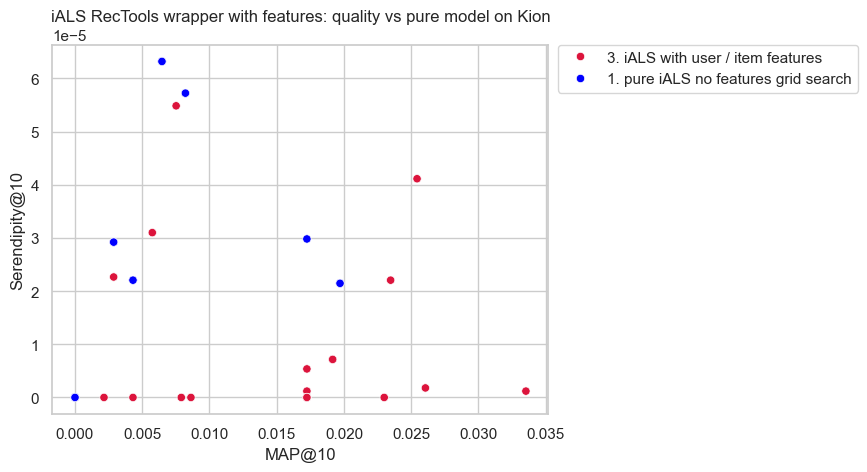

In [46]:
sns.scatterplot(data=all_df, x="MAP@10", y="Serendipity@10", hue="step", palette=["crimson", "blue", "skyblue"])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("iALS RecTools wrapper with features: quality vs pure model on Kion")
plt.show()

На полных данных будет вот так красиво:  

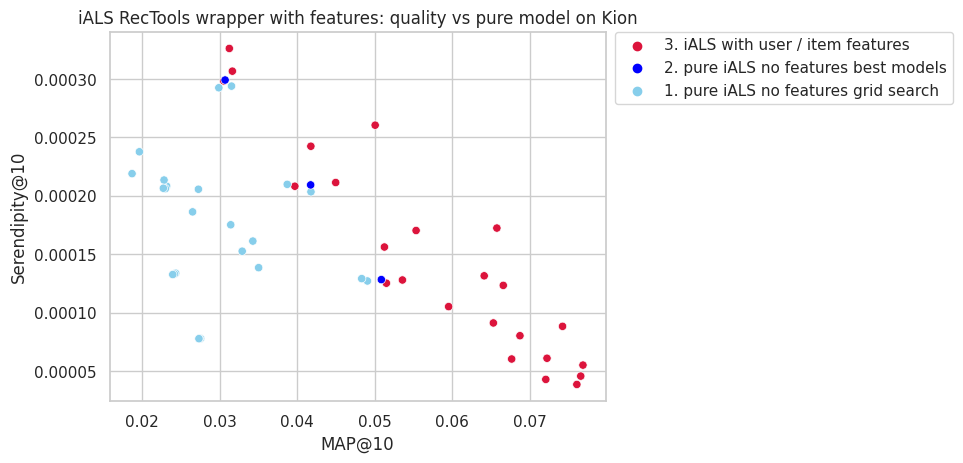